# Analysis of Internal Company Spending vs. Yearly Profit

## Import Libraries 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro

## Import Dataset

In [2]:
spending_profit = pd.read_csv("new_company_spending.csv")
#spending_profit.head(30)

## Fill in Missing Values and Normalize Data

In [3]:
# an anonymous fuction is applied to each row, excluding the 'State' and 'Profit' columns
#The function fills in each missing values with the mean spending for that company across all other departments
spending_profit.iloc[:, 1:-1] = spending_profit.iloc[:,1:-1].apply(lambda row:row.fillna(row.mean()), axis = 1)

# Name of "Profit" column is changed to "Profitability Ratio"
spending_profit = spending_profit.rename(columns = {"Profit" : "Profitability Ratio"})

# Dependent variable (profit) is normalized by dividing total profit by total internal spending
spending_profit["Profitability Ratio"] = (spending_profit["Profitability Ratio"]/(spending_profit.iloc[:,1:-1].apply(lambda row: row.sum(), axis = 1)))*100

#all rows where the value for "Profit" is missing are dropped
spending_profit = spending_profit.dropna(subset = ["Profitability Ratio"], how = "any")


#Total amount spent on each department is normalized to represent the percentage of total spending devoted to each 
spending_profit.iloc[:,1:-1] = spending_profit.iloc[:, 1:-1].apply(lambda row:((row/row.sum())*100), axis = 1)


#each numerical value is rounded to two decimal places 
spending_profit.iloc[:, 1:] = spending_profit.iloc[:,1:].apply(lambda row: row.round(2),axis = 1)

#Data is sorted by profitability ratio for each state listed in order or highest to lowest performance 
spending_profit = spending_profit.sort_values(by = ["State", "Profitability Ratio"], ascending = [True, False])
spending_profit.head(10)

,State,R&D Spend,Marketing Spend,Administration Spend,IT Spend,Logistics Spend,HR Spend,Sales Spend,Product Development Spend,Customer Support Spend,Legal Spend,Energy Spend,Research Spend,Profitability Ratio
843,California,42.50,19.43,4.16,11.19,0.54,3.34,1.32,6.68,0.29,1.28,3.78,5.49,24.73
842,California,40.26,23.16,5.02,9.19,0.22,0.63,2.21,5.94,3.60,3.07,3.99,2.72,23.08
325,California,42.83,13.80,4.77,7.14,8.29,0.89,4.78,6.79,4.24,1.18,1.98,3.30,22.51
656,California,36.83,14.33,11.59,10.58,1.87,2.96,9.36,7.07,1.31,3.54,0.38,0.19,22.41
101,California,44.64,6.01,5.97,12.45,3.03,2.73,0.64,5.90,5.79,3.41,2.30,7.13,21.07
748,California,43.13,2.79,15.54,5.48,5.64,3.59,6.35,4.33,3.05,4.06,4.13,1.91,21.07
292,California,35.50,17.73,8.50,9.15,4.16,4.08,9.12,0.52,1.67,2.73,3.30,3.54,20.99
81,California,31.42,14.63,4.24,12.47,6.60,5.09,7.60,4.44,3.21,1.82,5.22,3.28,20.75
931,California,44.31,6.43,2.05,11.28,0.95,0.72,15.36,2.36,1.89,2.07,6.67,5.91,20.59
648,California,37.24,11.54,16.79,5.36,0.70,4.11,11.90,1.91,4.12,1.20,4.23,0.90,20.41


## Split Data into Independent Features and Dependent Variable 

In [4]:
#dataset is split into an independent matrix of features (x) and a single dependent variable (y)
x = spending_profit.iloc[:, :-1].values 
y = spending_profit.iloc[:, -1].values

## Numerically Encode Categorical Data

In [5]:
# Categorical data in the "State" column is one-hot-encoded using the ColumnTransformer class 
ct = ColumnTransformer(transformers = [("state_encoder", OneHotEncoder(), [0])], remainder = "passthrough")
x = np.array(ct.fit_transform(x))

## Split Data into Training and Test Sets 

In [6]:
#The matrix of features and the dependent variable are split into training and test variables 
#80% of data is devoted to training while 20% is set aside for testing purposes 
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size = 0.2, random_state = 0)

## Instantiate and Train The Regression Model

In [7]:
#The linear regressor object is instantiated and trained using training data 
multiple_regressor = LinearRegression()
multiple_regressor.fit(train_x,train_y)

LinearRegression()

## Make Predictions and Evaluate Accuracy 

In [8]:
#Test data is fed to the regression model to generate a set of predictions about profitability 
y_test_predictions = multiple_regressor.predict(test_x)

#The actual profitability values and the predicted profitibility values are reshaped into vertical arrays
#This is in preparation for side by side comparison of predicted values and actual values 
y_test_prediction_vert = y_test_predictions.reshape(len(y_test_predictions), 1)
y_test_actual_vert = test_y.reshape(len(test_y), 1)

In [9]:
np.set_printoptions(precision = 2)
#The reshaped test_y values and the predicted values are concatenated together horizontally for side-by-side comparison
predictions_vs_testData = np.concatenate((y_test_prediction_vert,y_test_actual_vert), axis = 1)
#print(predictions_vs_testData)

In [10]:
#The code below iterates through the concatenated array and calculates the percent closeness of the two numbers 
#A new series is generated representing the percent accuracy of each prediction in comparison to the actual data value 
#The .describe() method is used to generate basic descriptive statistics about the predictice accuracy of the model 
percent_accuracy = []
for i in predictions_vs_testData:
    smaller = min(i[0],i[1])
    larger = max(i[0],i[1])
    percent_accuracy.append((smaller/larger)*100)

test_percent_accuracy = pd.Series(percent_accuracy)
test_percent_accuracy.describe()

count    200.000000
mean      94.813211
std        4.275363
min       68.693052
25%       93.001587
50%       95.513823
75%       98.030979
max       99.962600
dtype: float64

In [11]:
#A Shapiro-Wilk test is performed to determine the distribution normalcy of percent accuracy values
#The small p-value and test-statistic of 0.8 suggests that the data is statistically significant and deviates from normality
#The null hypotheses is rejected, implying that there is a significant relationship between the matrix of features and profitability

null_hypothesis = "there is no significant between internal spending and profit"
alternative_hypothesis = "there is a significant relationship between internal spending and profit"

stat, p_value = shapiro(percent_accuracy)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}\n")


if p_value > 0.05:
    print("The data appears to be normally distributed.")
    print(f"There is insufficient evidence to reject the null hypothesis that {null_hypothesis}")
else:
    print("The data does not appear to be normally distributed.\n")
    print(f"There is sufficient evidence to reject the null hypothesis.\nWe can assume the alternative hypothesis that {alternative_hypothesis}.")


Shapiro-Wilk Test Statistic: 0.8722450733184814, p-value: 5.931181761009707e-12

The data does not appear to be normally distributed.

There is sufficient evidence to reject the null hypothesis.
We can assume the alternative hypothesis that there is a significant relationship between internal spending and profit.


## Visualizing the Accuracy Data 

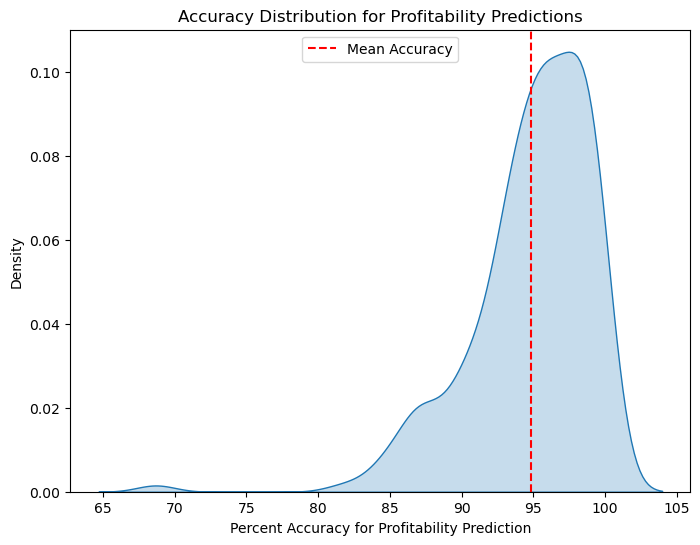

In [12]:
#A KDE plot is used to chart the distribution of percent accuracy calculations for the model's predicted values
#Accuracy curve demonstrates left skew, implying high accuracy in most cases 

plt.figure(figsize = (8,6))
sns.kdeplot(percent_accuracy, fill = True, bw_adjust = 0.9)
plt.axvline(x=np.mean(percent_accuracy), color='red', linestyle='--', label='Mean Accuracy')
plt.legend(loc = "upper center")
plt.title("Accuracy Distribution for Profitability Predictions")
plt.xlabel("Percent Accuracy for Profitability Prediction")
plt.show()

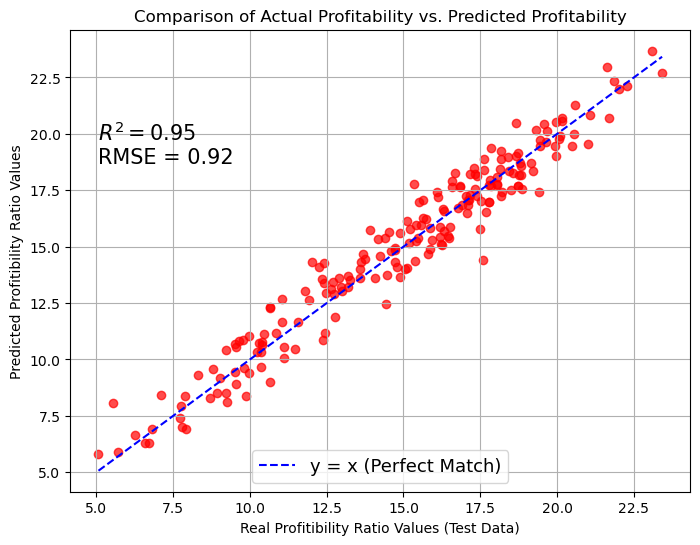

In [13]:
r_squared = r2_score(y_test_actual_vert, y_test_prediction_vert)
rmse = mean_squared_error(y_test_actual_vert, y_test_prediction_vert, squared=False)

#Predicted values of profitability are plotted against actual values 
#Trend line represents where the datapoints would be if predictions perfectly matched actual data 

plt.figure(figsize = (8,6))
plt.scatter(y_test_actual_vert,y_test_prediction_vert, color = "red", alpha=0.7)
plt.plot(
    [min(y_test_actual_vert), max(y_test_actual_vert)],
    [min(y_test_actual_vert), max(y_test_actual_vert)],
    'b--', label="y = x (Perfect Match)"
)
plt.xlabel("Real Profitibility Ratio Values (Test Data)")
plt.ylabel("Predicted Profitibility Ratio Values")
plt.title("Comparison of Actual Profitability vs. Predicted Profitability")
plt.text(min(y_test_actual_vert), max(y_test_prediction_vert) - 5, f"$R^2 = {r_squared:.2f}$\nRMSE = {rmse:.2f}", fontsize=15, color='black')
plt.legend(loc = "lower center", fontsize = 13)
plt.grid(True)
plt.show()

## Create Dictionary for One-Hot-Encoded Data

In [14]:
#one-hot-encoded sequences for each "State" category are extracted from the 'state_encoder' object
#A dictionary is defined, pairing each state with its corresponding sequence 


one_hot_encoder = ct.named_transformers_['state_encoder']

state_categories = one_hot_encoder.categories_[0] 

state_dict = {
    state: [1 if i == j else 0 for i in range(len(state_categories))]
    for j, state in enumerate(state_categories)
}

state_dict

{'California': [1, 0, 0, 0, 0],
 'Florida': [0, 1, 0, 0, 0],
 'Nevada': [0, 0, 1, 0, 0],
 'New York': [0, 0, 0, 1, 0],
 'Texas': [0, 0, 0, 0, 1]}

## Make a Profitability Prediction for a Single Company

In [15]:
#A single hypothetical company is fed into the model
#The model uses its state and departmental spending percentages to predict profitability ratio 

florida_test_case = [state_dict['Florida'] + [22.45, 12.3, 3.4, 4.6, 11.1, 25.11, 2.33, 1.24, 5.32, 6.12, 3.21, 2.8]]


predicted_profit_ratio = multiple_regressor.predict(florida_test_case)

print("This company will have a predicted profitability ratio of:", round(predicted_profit_ratio[0],2))

This company will have a predicted profitability ratio of: 14.53
